In [63]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [3]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# GW convergence analysis for the Germanene monolayer

We perform a convergence study for the GW runlevel

## HF Analysis

At this stage we do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters as

* RandGVec = 200
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 30x30x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on both EXXRLvcs and VXCRLvcs variables, since their values are subtracted__

In [4]:
input_dir = 'DFT_analysis/kpoints_30-nbnds_30.save'
run_dir = 'MB_analysis/kpoints_30-nbnds_30'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [5]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 91
RandGvec = 200
Randqpts = 5e6
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp

{'args': 'mpirun -np 1 yambo -r -x -V all',
 'folder': 'MB_analysis/kpoints_30-nbnds_30',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [28.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [63818.0, 'Kb'],
  'FFTGvecs': [14975.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [200, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [100555.0, 'RL'],
  'VXCRLvcs': [100555.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 91, 28, 29], ''],
  'QPerange': [[1, 91, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [6]:
study = D.Dataset(run_dir=run_dir,num_tasks=12,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.,60.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs,VXCRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 12 parallel tasks


In [7]:
#study.runs[8]

In [8]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
Skip the run ofSkip the run of  hf-G-exxrlvcs_30.0hf-G-exxrlvcs_20.0Skip the run of

 hf-G-exxrlvcs_60.0
Skip the run of hf-G-exxrlvcs_50.0
Skip the run of hf-G-exxrlvcs_10.0
Skip the run of hf-K-exxrlvcs_10.0
Skip the run of Skip the run ofSkip the run ofhf-K-exxrlvcs_50.0  
hf-K-exxrlvcs_30.0hf-K-exxrlvcs_60.0

Skip the run of hf-K-exxrlvcs_40.0
Skip the run of hf-K-exxrlvcs_20.0
Skip the run of hf-G-exxrlvcs_40.0
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] ended 
 


We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [9]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
#gap_G,gap_K

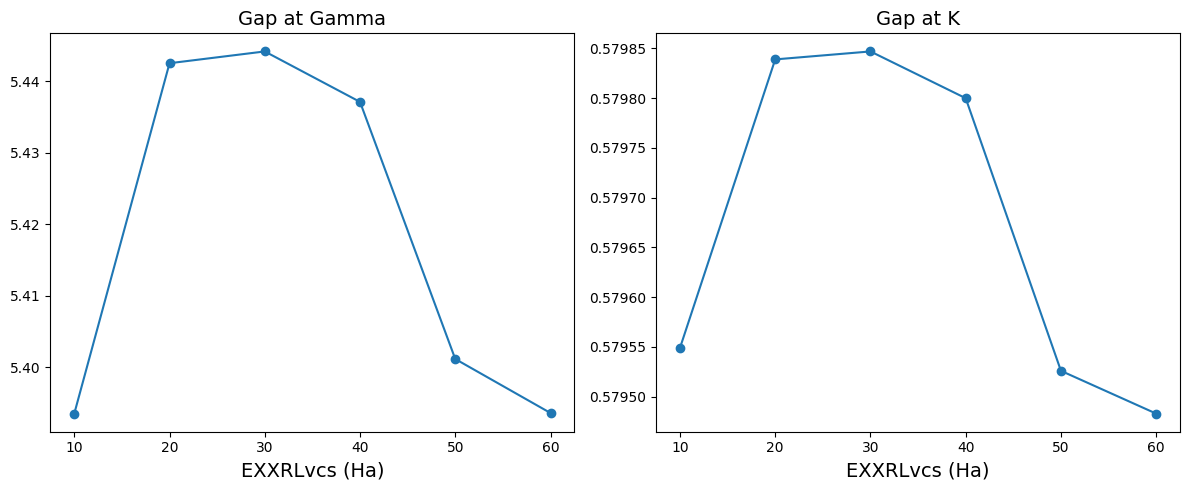

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 50 Ha

### HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [11]:
RandQpts = 5000000
RandGvec = 200 

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {18:1,30:1,42:1,60:1,72:1,81:1}
K_index = {30:91,42:169,60:331,72:469,81:588}

EXXRLvcs = 50. # Ha
EXXRLVcs_units = 'Ha'

In [12]:
kpoints = [30,42,60,72,81]

In [13]:
study = D.Dataset(num_tasks=10,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis/kpoints_%s-nbnds_30.save'%k
    run_dir = 'MB_analysis/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.4') 
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs'])
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs'])

Initialize a Dataset with 10 parallel tasks
SAVE folder MB_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_60-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_72-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_81-nbnds_30/SAVE already present. No operations performed.


In [14]:
#study.runs[1]

In [15]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run ofSkip the run of  hf-G-kpoints_30hf-K-kpoints_30

Skip the run of Skip the run ofhf-G-kpoints_60 
hf-G-kpoints_72
Skip the run of hf-K-kpoints_42
Skip the run of hf-K-kpoints_72
Skip the run of hf-K-kpoints_60
Skip the run ofSkip the run of  hf-G-kpoints_42hf-G-kpoints_81

Skip the run of hf-K-kpoints_81
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 


In [16]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([5.401141, 5.399132, 5.400971, 5.402111, 5.402411],
 [0.579527, 0.473071, 0.397227, 0.36955899999999997, 0.354848])

In [17]:
results_G = [results[k] for k in [0,2,4,6,8]]
results_K = [results[k] for k in [1,3,5,7,9]]
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([5.401141, 5.399132, 5.400971, 5.402111, 5.402411],
 [0.579527, 0.473071, 0.397227, 0.36955899999999997, 0.354848])

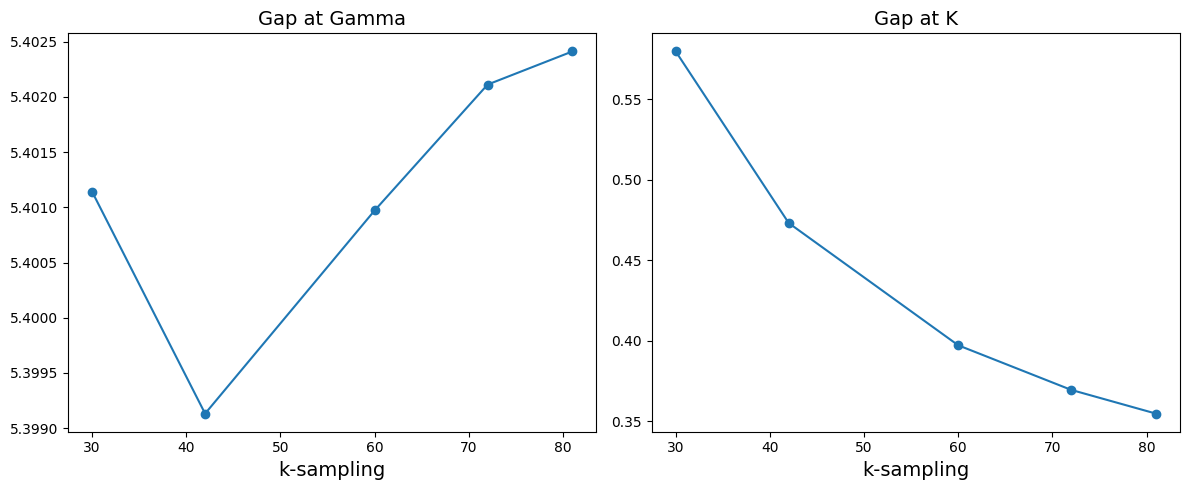

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

## Plasmon pole analysis

In [3]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We study the convergence of the gap at $\Gamma$ and at $K$ using the plasmon pole run level. 

### Convergence analysis of the screening

We use the 18x18x1 k-points sampling and perform a convergence analysis in the BndsRnXp and GbndRnge parameters
needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

__The variable LongDrXp is set to the inplane value [1,1,0]__ 

In [20]:
input_dir = 'DFT_analysis/kpoints_18-nbnds_800.save'
run_dir = 'MB_analysis/kpoints_18-nbnds_800'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')

SAVE folder MB_analysis/kpoints_18-nbnds_800/SAVE already present. No operations performed.


We the define the input variables common to all the runs

In [21]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 50. # Ha
EXXRLVcs_units = 'Ha'

LongDrXp=[1.,1.,0.] 

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on Leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

8 2


First we run over NGsBlkXp

In [22]:
NGsBlkXp = [4.0,6.0,8.0,10.,12.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,400] # Bands in the response function
GbndRnge = [1,400]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=10,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 10 parallel tasks


In [23]:
#study.runs[1]

In [24]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of Skip the run ofpp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400
 pp-G-ngsblkxp_4.0-bndsrnxp_400-gbndrnge_400
Skip the run ofSkip the run of pp-K-ngsblkxp_4.0-bndsrnxp_400-gbndrnge_400 
pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400
Skip the run of Skip the run ofpp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400 
pp-G-ngsblkxp_12.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-K-ngsblkxp_12.0-bndsrnxp_400-gbndrnge_400
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 


In [25]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([1.248202, 1.246634, 1.244256, 1.241928, 1.240968],
 [0.33681700000000003, 0.33468000000000003, 0.332433, 0.330998, 0.330174])

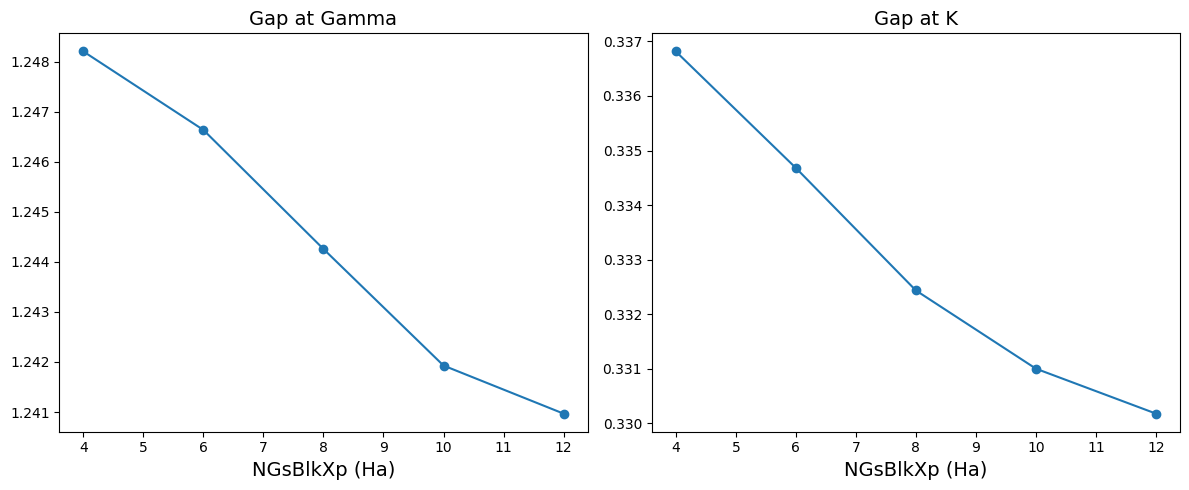

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We observe that the value NGsBlkXp = 10 Ha should ensures convergence at the level of 5 meV (or better) for
both the $\Gamma$ and the K points

#### Convergence of the BndsRnXp parameter

We perform a convergence analysis on the number of bands of the screening.For this analysis the
number of bands of the Green function is keep fixed at the value GbndRnge = 400

In [27]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 50. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 10.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500],[1,600]] # Bands in the response function
GbndRnge = [1,400]  # Bands in the Sigma_c

LongDrXp=[1.,1.,0.] 

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)

study = D.Dataset(num_tasks=8,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands)
    inp.set_array_variables(GbndRnge=GbndRnge)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False)
     # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False)

8 2
Initialize a Dataset with 8 parallel tasks


In [28]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7] 
Skip the run ofSkip the run of  pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_400pp-K-ngsblkxp_10.0-bndsrnxp_400-gbndrnge_400

 Skip the run ofpp-K-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_400
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_400-gbndrnge_400
Skip the run of Skip the run ofpp-K-ngsblkxp_10.0-bndsrnxp_500-gbndrnge_400 
pp-G-ngsblkxp_10.0-bndsrnxp_500-gbndrnge_400
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_400
Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_400
Task [0, 1, 2, 3, 4, 5, 6, 7] ended 
 


In [29]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([1.2326009999999998, 1.241928, 1.247047, 1.2501790000000002],
 [0.324121, 0.330998, 0.33442299999999997, 0.336387])

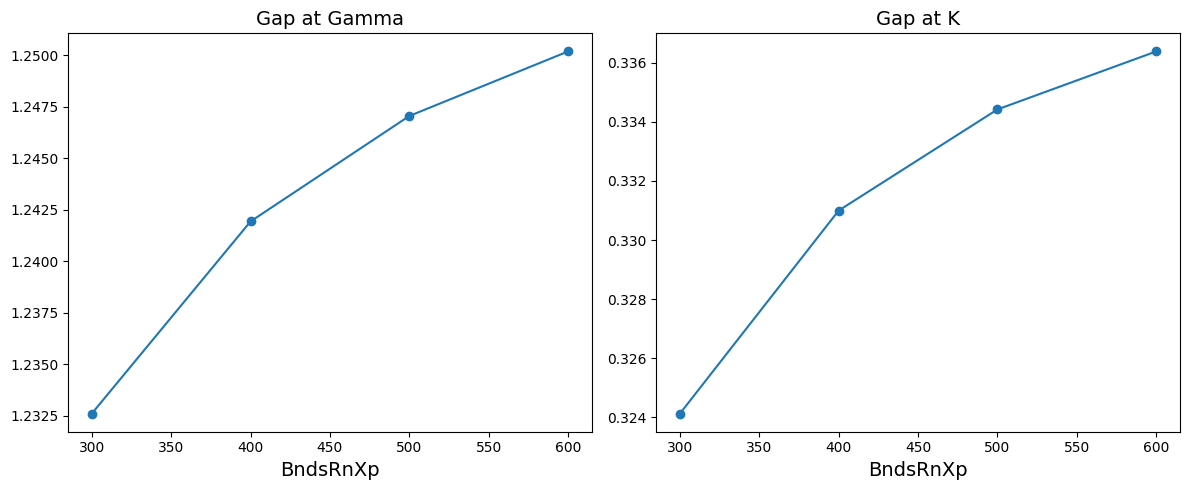

In [30]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('BndsRnXp',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('BndsRnXp',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we conclude that NGsBlkXp = 10 Ha, BndsRnXp = 600 seems to ensure
 convergence within 5 meV.

#### Convergence of the GbndRnge parameter

We perform a convergence analysis on the number of bands of the G function. We also test the effects of the terminator on the G function.

In [31]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 50. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 10.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,600] # Bands in the response function
Bands  = [[1,400],[1,500],[1,600],[1,700],[1,800]] # Bands in the Sigma_c 

LongDrXp=[1.,1.,0.] 

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp)

study = D.Dataset(num_tasks=20,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
     # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

for bands in Bands:
    inp.set_array_variables(GbndRnge=bands)
    inp.set_scalar_variables(GTermKind='BG')
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
     # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-Gterm'%(NGsBlkXp,BndsRnXp[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)

8 2
Initialize a Dataset with 20 parallel tasks


In [32]:
#study.runs[0]

In [33]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_400
Skip the run ofSkip the run of  pp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_500pp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_400

Skip the run of Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_500Skip the run of
pp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_600 
pp-K-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_600
Skip the run of pp-K-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_700
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_700
Skip the run of Skip the run ofpp-K-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_800 
Skip the run ofpp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_800 
Skip the run ofpp-G-ngsblkxp_10.0-bndsrnxp_600-gbndrnge_400-Gterm
 pp-G-ngsblkxp_10.0-bndsrnxp_

In [34]:
gap_G = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in [0,2,4,6,8]]
gap_K = [results[ind].data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for ind in [1,3,5,7,9]]
gap_G_Gterm = [results[ind].data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for ind in [10,12,14,16,18]]
gap_K_Gterm = [results[ind].data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for ind in [11,13,15,17,19]]
gap_G,gap_G_Gterm,gap_K,gap_K_Gterm

([1.2501790000000002, 1.274543, 1.290891, 1.302125, 1.310267],
 [1.350547, 1.350479, 1.350903, 1.350792, 1.3506179999999999],
 [0.336387, 0.353008, 0.36424, 0.371714, 0.37728],
 [0.401197, 0.401436, 0.40191599999999994, 0.40191099999999996, 0.401927])

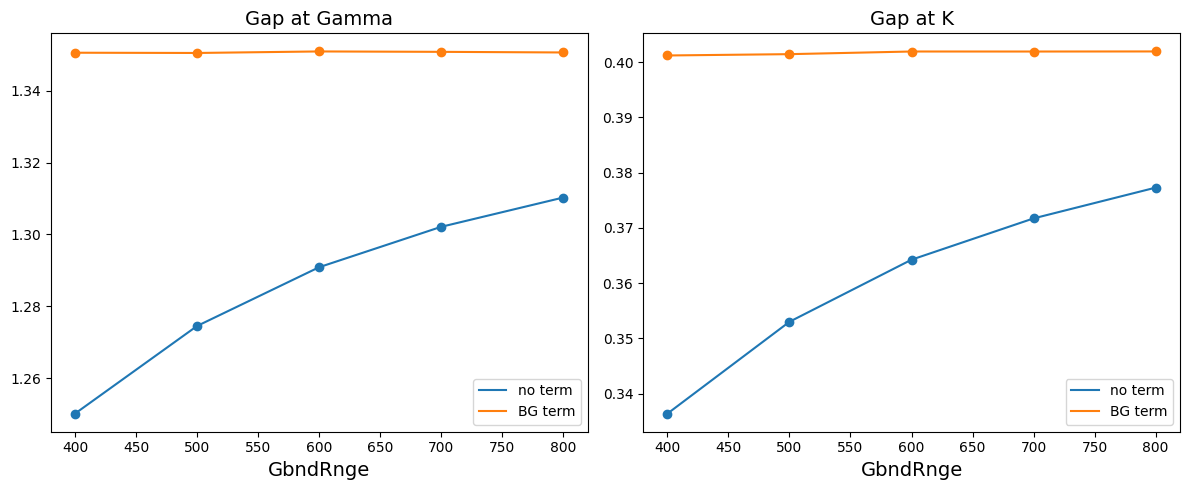

In [35]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G,label='no term')
axes[0].scatter(x_vals,gap_G)
axes[0].plot(x_vals,gap_G_Gterm,label='BG term')
axes[0].scatter(x_vals,gap_G_Gterm)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('GbndRnge',size=14)
axes[0].legend()
axes[1].plot(x_vals, gap_K,label='no term')
axes[1].scatter(x_vals,gap_K)
axes[1].plot(x_vals, gap_K_Gterm,label='BG term')
axes[1].scatter(x_vals,gap_K_Gterm)
axes[1].set_xlabel('GbndRnge',size=14)
axes[1].set_title('Gap at K',size=14)
axes[1].legend()
fig.tight_layout()

On the basis of this analysis we conclude that the optimal parameters for the convergence of the screening are

NGsBlkXp = 10.0 # Ha G size of the response function

BndsRnXp = [1,600]

GbndRnge = [1,400] with BG terminator

### Convergence analysis of the k-points sampling

In [10]:
# RunRules for leonardo
nodes = 8
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 8,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We test the effect of the k-points sampling on the GW correction ast the pp level.

In [11]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_800','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_600','K_index':331,'G_index':1},
             '72x72x1': {'folder':'kpoints_72-nbnds_600','K_index':469,'G_index':1},
            }

In [12]:
for k in ksamplings:
    input_dir=os.path.join('DFT_analysis',ksamplings[k]['folder']+'.save')
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')

SAVE folder MB_analysis/kpoints_18-nbnds_800/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_60-nbnds_600/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_72-nbnds_600/SAVE already present. No operations performed.


In [13]:
ntasks_c = 16 #8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha
NGsBlkXp = 10.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,600]
GbndRnge  = [1,400] # Bands in the G function
LongDrXp=[1.,1.,0.] 

study = D.Dataset(num_tasks=8,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_array_variables(LongDrXp=LongDrXp)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    #inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 8 nodes on leonardo
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(GTermKind='BG')
    # append run at G
    idd = 'pp-G-kpoints_%s'%k
    inp.set_kRange(ksamplings[k]['G_index'],ksamplings[k]['G_index'])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-kpoints_%s'%k
    inp.set_kRange(ksamplings[k]['K_index'],ksamplings[k]['K_index'])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


16 2
Initialize a Dataset with 8 parallel tasks


In [14]:
study.ids

['pp-G-kpoints_18x18x1',
 'pp-K-kpoints_18x18x1',
 'pp-G-kpoints_60x60x1',
 'pp-K-kpoints_60x60x1',
 'pp-G-kpoints_72x72x1',
 'pp-K-kpoints_72x72x1']

In [15]:
#study.runs[4]

In [16]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1, 2, 3, 4, 5]] 

Run the task [0, 1, 2, 3, 4, 5] 
Skip the run of pp-G-kpoints_18x18x1
Skip the run ofSkip the run of Skip the run ofpp-K-kpoints_18x18x1 
 pp-G-kpoints_72x72x1pp-K-kpoints_60x60x1

Skip the run ofSkip the run of pp-G-kpoints_60x60x1 
pp-K-kpoints_72x72x1
Task [0, 1, 2, 3, 4, 5] ended 
 


In [17]:
ksamplings

{'18x18x1': {'folder': 'kpoints_18-nbnds_800', 'K_index': 37, 'G_index': 1},
 '60x60x1': {'folder': 'kpoints_60-nbnds_600', 'K_index': 331, 'G_index': 1},
 '72x72x1': {'folder': 'kpoints_72-nbnds_600', 'K_index': 469, 'G_index': 1}}

In [19]:
G_index = 1
K_index = [37,37,331,331,469,469]

In [24]:
gap_G = [results[ind].data.get_gap(k_full=G_index,band_full=start_band,verbose=False) for ind in [0,2,4]]
gap_K = [results[ind].data.get_gap(k_full=K_index[ind],band_full=start_band,verbose=False) for ind in [1,3,5]]
gap_G,gap_K

([1.350546, 1.385883, 1.393477], [0.401197, 0.12700999999999996, 0.108232])

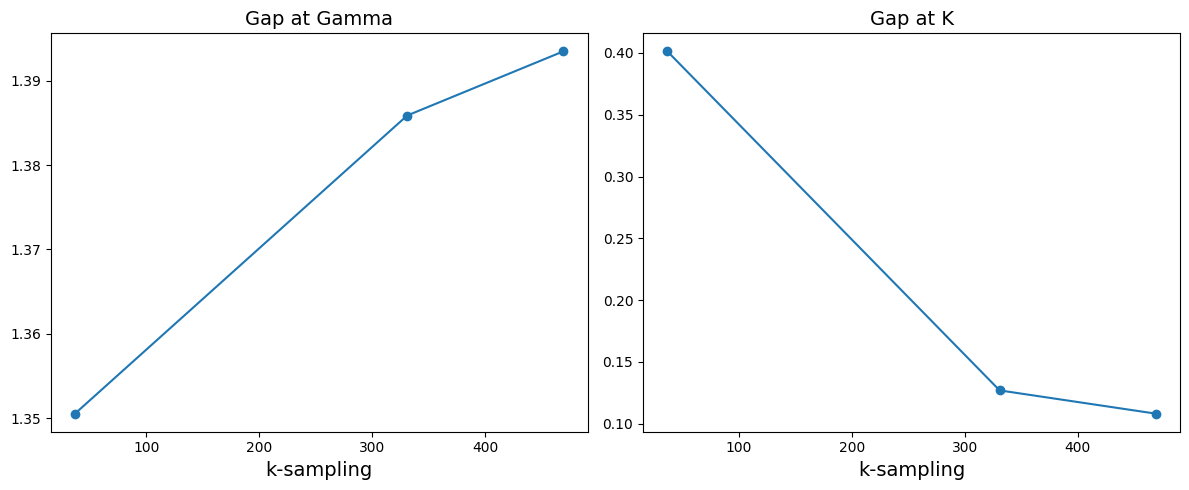

In [25]:
kpoints =  [37,331,469]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_xlabel('k-sampling',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We extrapolate the value of the gap at K using an exponential fit

In [61]:
import scipy

In [62]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

The asymptotic gap is equal to  0.099  eV


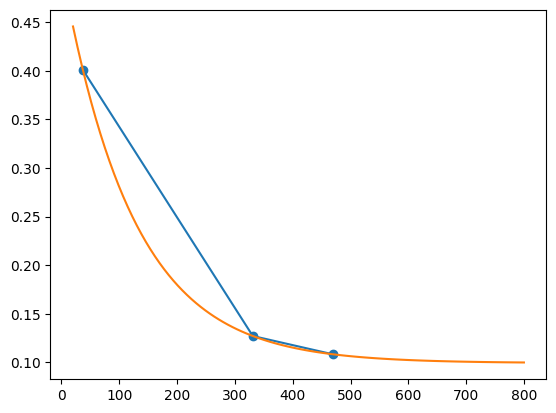

In [67]:
xs = np.array(kpoints)
xfit = np.linspace(20,800,100)
p0 = [1,0.01,0.1]
params, cv = scipy.optimize.curve_fit(monoExp, xs, gap_K, p0)
m, t, b = params
fit = monoExp(xfit, m, t, b)
plt.plot(kpoints,gap_K)
plt.scatter(kpoints,gap_K)
plt.plot(xfit,fit)
print('The asymptotic gap is equal to ',np.round(b,decimals=3),' eV')

## Quasi-particle band structure

In [3]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We use the convergence test performed above to computed the GW correction in the whole BZ. 
In this way we can compute the quasi-particle correction of the band structure.

In order to aviod a great (and not necessary) computational load we try to compute the GW correction for a subset
of the whole sampling of the BZ and we build the GW band structure using ypp on the basis of the computed points. 

To this aim we need to perform a separate calculation for each k point and then we merge the ndb.QP to build the complete
database used by ypp.

We work in the 72x72x1 kpoints grid.

In [4]:
kpoints = 72
run_dir = 'MB_analysis/kpoints_%s-nbnds_600'%kpoints

In [5]:
nsdb = os.path.join(run_dir,'SAVE/ns.db1')
dft_data = P.YamboDftParser(nsdb)

Parse file : MB_analysis/kpoints_72-nbnds_600/SAVE/ns.db1


In [6]:
kpoints_all = dft_data.get_kpoints(use_scalar_alat=True)

number of kpoints = 469


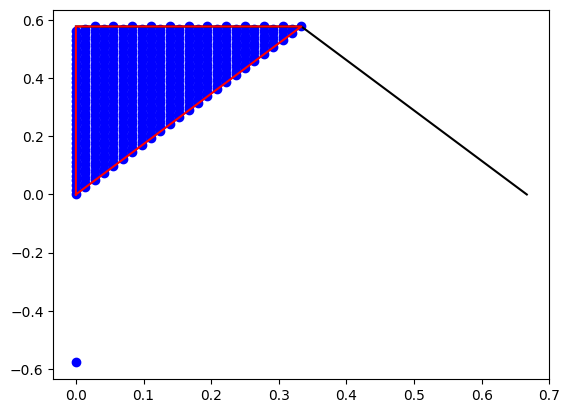

In [7]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kpoints_all))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kpoints_all[:,0],kpoints_all[:,1],c='blue')

We build a reduced array with a subset of kpoints close to the path on which we compute the GW band structure

The ind_path list contains the ordered list of all the kpoint along the selected path.
The values start from 1 for k the first point up to 469 for the last one

In [10]:
from mppi.Utilities import Utils

ind_path_GM, ind_path_MK, ind_path_KG = [],[],[]
tol = 0.005
for ind in range(len(kpoints_all)):
    Point = kpoints_all[ind][0],kpoints_all[ind][1]
    if U.Utils.is_point_near_line(Point,Gamma,Mp,tol): 
        ind_path_GM.append(ind+1)
    elif U.Utils.is_point_near_line(Point,Mp,Kp,tol): 
        ind_path_MK.append(ind+1)
    elif U.Utils.is_point_near_line(Point,Kp,Gamma,tol): 
        ind_path_KG.append(ind+1)     

ind_path = []
ind_path.extend(ind_path_GM)
ind_path.extend(ind_path_MK)
ind_path.extend(ind_path_KG[::-1]) # this list is reversed
#ind_path

number of sampled kpoints = 71


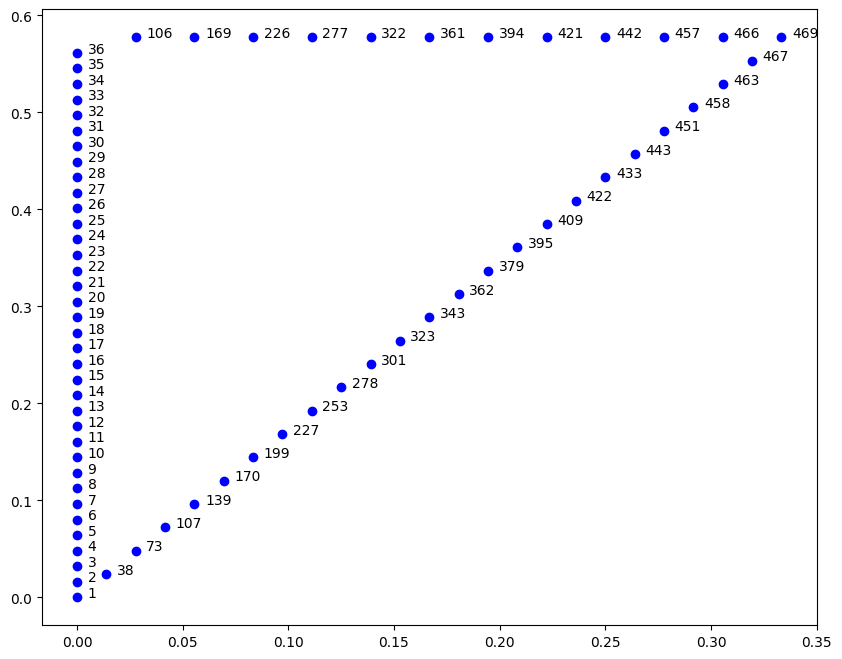

In [10]:
fig, ax1 = plt.subplots(figsize=(10,8))

print('number of sampled kpoints = %s'%len(ind_path))
for ind in ind_path:
    plt.scatter(kpoints_all[ind-1,0],kpoints_all[ind-1,1],c='blue')
    plt.text(kpoints_all[ind-1,0]+0.005,kpoints_all[ind-1,1],ind)

In [11]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,32
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 50. # Ha
NGsBlkXp = 10.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,600]
GbndRnge  = [1,400] # Bands in the G function
LongDrXp=[1.,1.,0.] 

study = D.Dataset(num_tasks=16,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(GTermKind='BG')
for ind in ind_path:
    idd = 'pp-BZ-kpoint_%s'%(ind)
    inp.set_kRange(ind,ind)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_10.0-bndsrnxp_600'],reformat=False)

8 2
Initialize a Dataset with 16 parallel tasks


In [12]:
#study.ids

In [13]:
#study.runs[70]

In [ ]:
results = study.run() #selection=[ind for ind in range(60,71)]

Once that the runs are performed we build the bands structure. To this scope we need to define
an instance of BandStructure class

In [16]:
ind_path.extend([1]) # ad Gamma at the end to close the path

In [17]:
kpoints_sampled = []
for ind in ind_path:
    kpoints_sampled.append(kpoints_all[ind-1])
kpoints_sampled = np.array(kpoints_sampled)
kpoints_sampled.shape

(72, 3)

In [18]:
data_dft = np.zeros((8,len(ind_path)))
data_gw = np.zeros((8,len(ind_path)))
data_dft.shape

(8, 72)

In [19]:
for ind in range(len(ind_path)):
    data = P.YamboOutputParser.from_file(os.path.join(run_dir,'pp-BZ-kpoint_%s/o-pp-BZ-kpoint_%s.qp'%(ind_path[ind],ind_path[ind])),verbose=False)
    data_dft[:,ind] = data['qp']['E0']
    data_gw[:,ind] = data['qp']['E']
valence_ind = 3
data_gw = data_gw-max(data_gw[valence_ind]) # shift the maximum of the gw valence band to zero

In [20]:
1/np.sqrt(3)

0.5773502691896258

In [21]:
Gamma = np.array([0.,0.,0.])
Kp = np.array([1./3.,1./np.sqrt(3),0.])
#Mp = np.array([0.,1./np.sqrt(3),0.])
Mp = np.array([0.,0.5613128,0.]) # use this approximated value beacuse computation at M is lacking for symmetry reasons

high_sym = {'G':Gamma,'K':Kp,'M':Mp} # in cartesian coordinates
high_sym

{'G': array([0., 0., 0.]),
 'K': array([0.33333333, 0.57735027, 0.        ]),
 'M': array([0.       , 0.5613128, 0.       ])}

In [27]:
kpoints_sampled.shape,data_dft.shape,data_gw.shape

((72, 3), (8, 72), (8, 72))

We write the relevant arrays on a file for subsequent import procedure.
Bands arrays have been trasposed to ease the dum on file.

In [83]:
from mppi.Utilities.Utils import array_dump_to_file, file_parser

In [82]:
array_dump_to_file(kpoints_sampled,os.path.join(run_dir,'kpoints_sampled.log'),columns=['x','y','z'])
col_name = [f"band{i}" for i in range(25,33)]
array_dump_to_file(data_dft.T,os.path.join(run_dir,'data_dft.log'),columns=col_name)
array_dump_to_file(data_gw.T,os.path.join(run_dir,'data_gw.log'),columns=col_name)

In [20]:
bands_dft = U.BandStructure(kpoints_sampled,data_dft,high_sym_points=high_sym) 
bands_gw = U.BandStructure(kpoints_sampled,data_gw-max(data_gw[3]),high_sym_points=high_sym)

In [21]:
max(bands_dft.kpath)

1.565610097721219

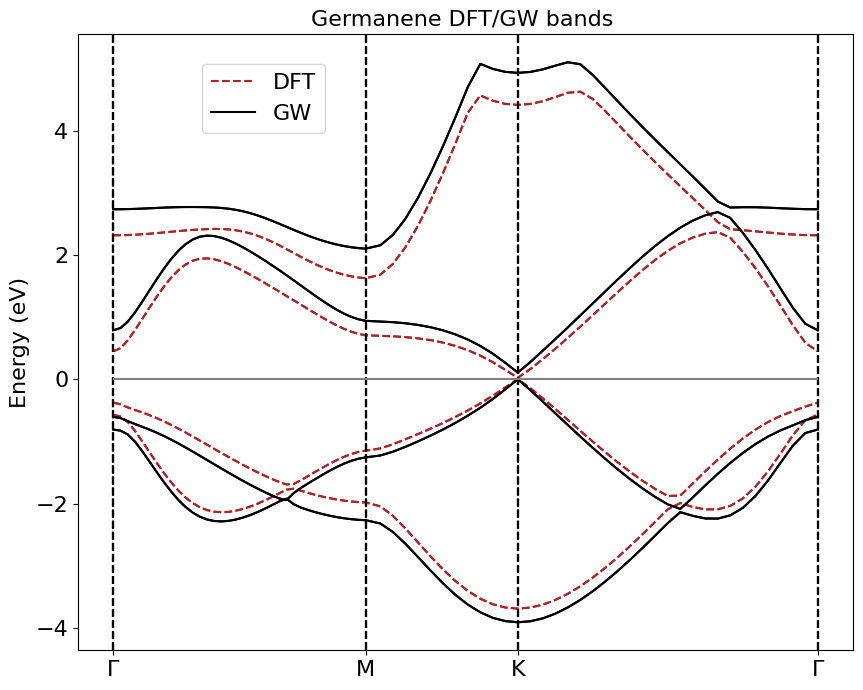

In [24]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='DFT',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='GW',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,max(bands_dft.kpath),linestyles='-',color='gray')
#ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Germanene DFT/GW bands ',size=16)
ax1.legend(loc=(0.16,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

0.108232


/scratch_local/ipykernel_134244/115620859.py:20: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax1, [0.065,0.7,0.3,0.28])


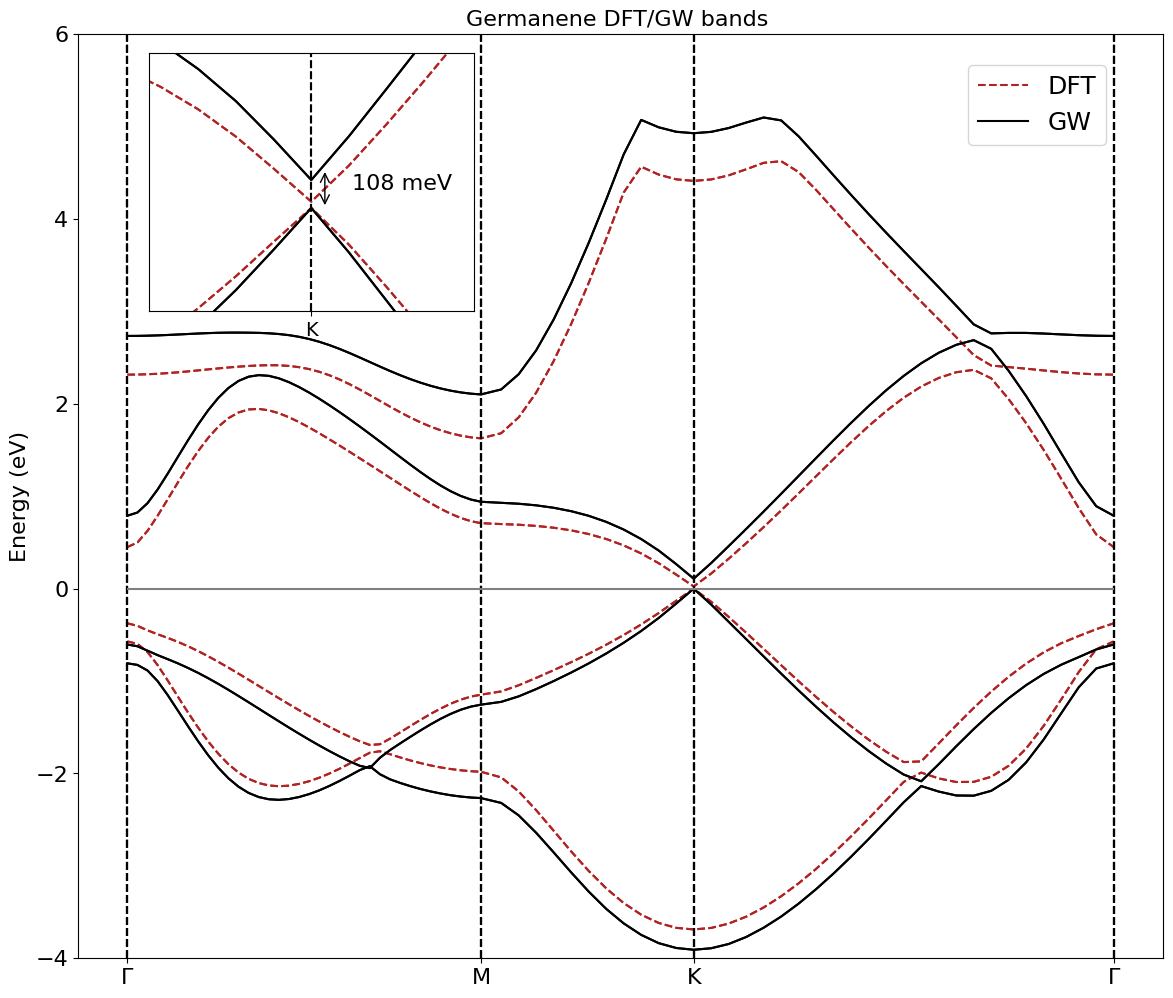

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
K_position = bands_dft.get_high_sym_positions()[1][2]
shift = 0.12
gap = min(bands_gw.bands[4])-max(bands_gw.bands[3])
print(gap)

fig, ax1 = plt.subplots(figsize=(14,12))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='DFT',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='GW',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,max(bands_dft.kpath),linestyles='-',color='gray')
ax1.set_ylim(-4.0,6)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Germanene DFT/GW bands ',size=16)
ax1.legend(loc=(0.82,0.88),fontsize=18,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.065,0.7,0.3,0.28])
ax2.set_axes_locator(ip)
bands_dft.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='-',c='black')
ax2.annotate('', xy=(K_position+0.01, 0), xytext=(K_position+0.01, 0.15), arrowprops=dict(arrowstyle='<->'),size=16)
ax2.text(K_position+0.03,0.07,'108 meV',size=16)
ax2.set_yticks([])
ax2.set_xlim(K_position-shift,K_position+shift)
ax2.set_ylim(-0.4,0.6)

#plt.savefig(fname='Plot/Germanene-band_structure-kpoints_%s.eps'%kpoints,format='eps',bbox_inches = "tight")
plt.savefig(fname='Plot/Germanene-band_structure-kpoints_%s.jpg'%kpoints,format='jpeg',bbox_inches = "tight")